# UNet++ (SAR to Optical)

### Mount Google Drive

In [1]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd '/gdrive/My Drive/CI2020-hackathon/James/'

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
import pandas as pd
import torch
import time
import pandas as pd
import os
import glob
import cv2

2024-05-19 12:55:53.974488: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 12:55:54.316484: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 12:55:54.316520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 12:55:54.370550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 12:55:54.511158: I tensorflow/core/platform/cpu_feature_guar

In [2]:
device='gpu' # 'tpu'/'gpu'

In [3]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [4]:
if device=='gpu':
  gpu_info = os.system('nvidia-smi')
  # print('\n'.join(gpu_info))
  device='cuda:0'

Sun May 19 12:55:58 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.01             Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   35C    P0              12W /  99W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Data Creation (Agri Only)

Put the data here

### Configuration

In [41]:
IMG_SIZE = 127

In [42]:
!pwd

/home/tamal/projects/Ecometric/ci2020-hackathon


### Load Image Data

In [43]:
main_dir = '/home/tamal/projects/Ecometric/ci2020-hackathon'
data_dir = os.path.join(main_dir, 'v_2')

In [44]:
all_regions = ['agri', 'barrenland', 'grassland', 'urban']
regions = ['agri']

data = {'sar': [], 'optical':[]}


for region in regions:
    data_dir = os.path.join(data_dir, region)
    sar_imgs= [os.path.join(data_dir, 's1', i) for i in sorted(os.listdir(os.path.join(data_dir, 's1'))) if i.endswith('.png')]
    optical_imgs= [os.path.join(data_dir, 's2', i) for i in sorted(os.listdir(os.path.join(data_dir, 's2'))) if i.endswith('.png')]
    

print(sar_imgs[:10])
print(optical_imgs[:10])

['/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p10.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p100.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1000.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1001.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1002.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1003.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1004.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1005.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1006.png', '/home/tamal/projects/Ecometric/ci2020-hackathon/v_2/agri/s1/ROIs1868_summer_s1_59_p1007.png']
['/home/tamal/projects/Ecometric/ci2020-hackathon/v_

In [ ]:
sar_np = np.zeros((len(sar_imgs), IMG_SIZE, IMG_SIZE, 3), dtype='int')
optical_np = np.zeros((len(sar_imgs), IMG_SIZE, IMG_SIZE, 3), dtype='int')


for i,sar_img_path in enumerate(sar_imgs):
    sar_img = cv2.imread(sar_img_path)
    sar_img = cv2.resize(sar_img, (IMG_SIZE,IMG_SIZE))
    sar_np[i] = sar_img
    # plt.imshow(sar_img)
    # break

for i,optical_img_path in enumerate(optical_imgs):
    optical_img = cv2.imread(optical_img_path)
    optical_img = cv2.resize(optical_img, (IMG_SIZE,IMG_SIZE))
    optical_np[i] = optical_img
    

# print(sar_np[0], optical_np[0])

In [47]:
# np.save('sar_agri.npy', sar_np, )
# np.save('optical_agri.npy', optical_np)

In [18]:
print(len(sar_imgs), len(optical_imgs))

4000 4000


### Load Saved Data

In [5]:
SAMPLES = 2000

CloudTop = np.load("./sar_agri.npy")[:SAMPLES] #np.random.random((1000,127,127,3))
TrueColor = np.load("./optical_agri.npy")[:SAMPLES] #np.random.random((1000,127,127,3))
TrueColor.shape, CloudTop.shape

((2000, 127, 127, 3), (2000, 127, 127, 3))

### Preprocessing

Get rid of dark images

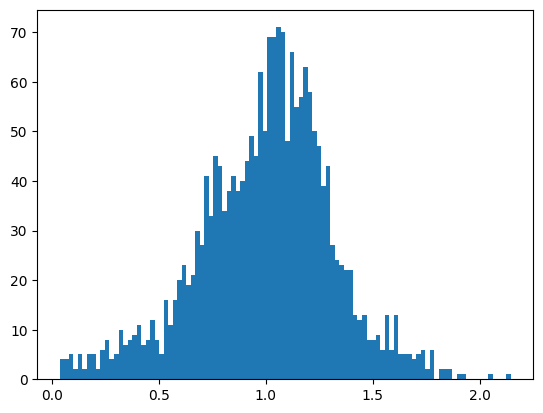

In [7]:
mask = np.where(np.sum(TrueColor,axis=(1,2,3))>0.)
TrueColorNZ = TrueColor[mask]
CloudTopNZ = CloudTop[mask]

# examine average intensities
saturation = ( TrueColorNZ.mean(axis=(1,2)) / (TrueColorNZ.mean(axis=(1,2)).mean(0)) ).mean(axis=1)
plt.hist(saturation, bins=100);
plt.show()

In [8]:
# cutoff intensity
min_saturation = 0.6

TrueColorNZ = TrueColorNZ[saturation > min_saturation]
CloudTopNZ = CloudTopNZ[saturation > min_saturation]

In [9]:
TrueColorNZ.shape, CloudTopNZ.shape

((1801, 127, 127, 3), (1801, 127, 127, 3))

In [10]:
del CloudTop, TrueColor



### U-Net++

In [11]:
from lib.unet_plus import NestedUNet
from lib.ssim import SSIM

calc_ssim = SSIM()
loss_fn = lambda x1, x2: -calc_ssim(x1,x2)

In [12]:
model = NestedUNet(num_classes=3, input_channels=3, deep_supervision=False, nb_filter=[8, 16, 32, 64, 128],).to(device)
optim = torch.optim.Adam(model.parameters())

In [13]:
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4          [-1, 8, 128, 128]             584
       BatchNorm2d-5          [-1, 8, 128, 128]              16
              ReLU-6          [-1, 8, 128, 128]               0
          VGGBlock-7          [-1, 8, 128, 128]               0
         MaxPool2d-8            [-1, 8, 64, 64]               0
            Conv2d-9           [-1, 16, 64, 64]           1,168
      BatchNorm2d-10           [-1, 16, 64, 64]              32
             ReLU-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 16, 64, 64]           2,320
      BatchNorm2d-13           [-1, 16, 64, 64]              32
             ReLU-14           [-1, 16,

### Dataloader

In [14]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

def pad(data):
  return F.pad(input=data, pad=(0, 1, 0, 1), mode='constant', value=0)

In [15]:
batch_size = 10
test_size=50

tensor_x = pad(torch.from_numpy(CloudTopNZ.transpose((0,3,1,2))/255)).float()
tensor_y = torch.from_numpy(TrueColorNZ.transpose((0,3,1,2))/255.).float()

dataset = TensorDataset(tensor_x,tensor_y)

# split into train and test sets and create dataloader
train_set, test_set = torch.utils.data.random_split(dataset, (len(dataset)-test_size, test_size), generator=torch.Generator().manual_seed(42))
dataloader = DataLoader(train_set, batch_size=batch_size)

test_X, test_y = test_set[:]
test_X = test_X.to(device)
test_y = test_y.to(device)

del tensor_x, tensor_y, train_set, test_set, dataset, CloudTopNZ, TrueColorNZ

In [16]:
!nvidia-smi

Sun May 19 12:58:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.01             Driver Version: 537.70       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8               2W / 110W |    192MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [17]:
dataloader.dataset.dataset.tensors[0].device

device(type='cpu')

In [18]:
test_X.device

device(type='cuda', index=0)

### Training Loop

In [19]:
STATS_PERIOD = 50
MODEL_DUMP_ROOT="output_dump"

N=50

class net_container:
    def __init__(self, net, optimizer, loss_func, test_X, test_y, run_name=None):
        self.net = net
        self.optimizer = optimizer
        self.loss_func = loss_func
        self.run_name = run_name
        self.test_X = test_X.float()
        self.test_y = test_y.float()
        
        self.running_train_loss = 0
        self.train_losses = []
        self.test_losses = []
        self.batch = []
        self.time_elapsed = []
        
    
    def train_step(self, X, y, batch_number):
        


        # forward + backward + optimize
        self.net.train()
        
        outputs = self.net(X)[:,:,:-1, :-1]
        train_loss = self.loss_func(outputs, y)

        self.running_train_loss += train_loss.item()
        
        train_loss.backward()
        self.optimizer.step()

        # zero the parameter gradients
        self.optimizer.zero_grad()

        del outputs, train_loss

        # print statistics
        if batch_number == 0 or batch_number % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches

            # Train loss
            if batch_number == 0:
                mean_train_loss = self.running_train_loss
                self.t0 = time.time()
            else:
                mean_train_loss = self.running_train_loss / STATS_PERIOD

            self.train_losses.append(mean_train_loss)
            
            self.running_train_loss = 0.

            # Test loss
            self.net.eval()
            
            test_loss=0
            for i in range((self.test_X.shape[0]-1)//N + 1):
            #   print(self.test_X.dtype)
              test_outputs = self.net(self.test_X[i*N:(i+1)*N])[:,:,:-1, :-1]
              l = self.loss_func(test_outputs, self.test_y[i*N:(i+1)*N]).item()
              l = l * min(N, self.test_X.shape[0]-i*N)/self.test_X.shape[0]
              test_loss += l

            self.test_losses.append(test_loss)
           
            self.batch.append(batch_number)
            self.time_elapsed.append(time.time() - self.t0)

            print(f"batch {batch_number} | {self.time_elapsed[-1]}s elapsed | train_loss {mean_train_loss:.5f} | test_loss {self.test_losses[-1]:.5f}"+" "*10, flush=True)
            
            if self.run_name:
                thisdir = os.path.join(MODEL_DUMP_ROOT, self.run_name)
                if batch_number==0:
                    
                    os.system(f"rm -rf {thisdir}")
                    os.makedirs(thisdir)
                    
                              
                df = pd.DataFrame({
                    'time_elapsed':self.time_elapsed,
                    'batch':self.batch,
                    'train_loss':self.train_losses,
                    'test_loss':self.test_losses,
                }).to_csv(os.path.join(thisdir, 'training_stats.csv'))
                
                if test_loss == min(self.test_losses):
                    torch.save(self.net, os.path.join(thisdir, 'best_model.pkl'))

In [21]:
wrapped_model = net_container(model, optim, loss_fn, test_X, test_y, run_name='unet8')

bn = 0

In [22]:
batch_epochs=[(10, 60), (32, 30), (64, 30), (128, 20), (256, 20)]

for batch_size, epochs in batch_epochs:

  print(f"transition to (batch:{batch_size}, epochs: {epochs})")
  dataloader = DataLoader(dataloader.dataset, batch_size=batch_size)

  for _ in range(epochs):
      
      for X, y in dataloader:
          X = X.to(device)
          y = y.to(device)
          # print(X.size(), y.size())
          X, y = X.float(), y.float()
          # print(X.dtype, y.dtype)
          # print(X)
          wrapped_model.train_step(X,y,bn)
          bn+=1

transition to (batch:10, epochs: 60)
batch 0 | 0.38190317153930664s elapsed | train_loss -0.03430 | test_loss -0.09382          
batch 49 | 1.8178074359893799s elapsed | train_loss -0.23264 | test_loss -0.26116          
batch 99 | 3.166451930999756s elapsed | train_loss -0.34810 | test_loss -0.25379          
batch 149 | 4.490196228027344s elapsed | train_loss -0.36149 | test_loss -0.25570          
batch 199 | 5.9135167598724365s elapsed | train_loss -0.36186 | test_loss -0.36256          
batch 249 | 7.263164520263672s elapsed | train_loss -0.37722 | test_loss -0.36948          
batch 299 | 8.576728820800781s elapsed | train_loss -0.38694 | test_loss -0.38948          
batch 349 | 9.891887903213501s elapsed | train_loss -0.37673 | test_loss -0.35489          
batch 399 | 11.177303314208984s elapsed | train_loss -0.38414 | test_loss -0.38528          
batch 449 | 12.4888334274292s elapsed | train_loss -0.39184 | test_loss -0.39734          
batch 499 | 13.836096286773682s elapsed | t

## Evaluate and reload best model

### Performance Measure

<Axes: xlabel='time_elapsed'>

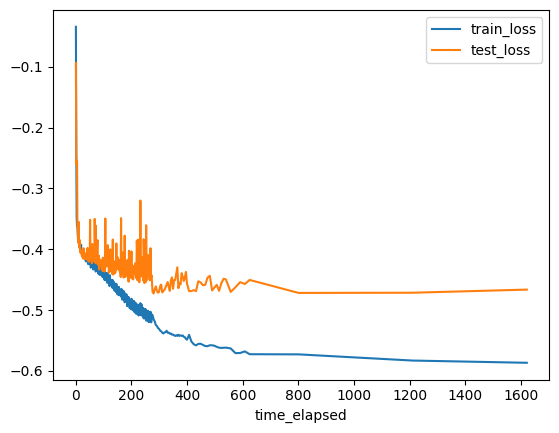

In [23]:
df = pd.read_csv('output_dump/unet8/training_stats.csv')
df = df[df.train_loss>-1]
df.plot(x='time_elapsed', y=['train_loss', 'test_loss'])

In [25]:
df.test_loss.min()

-0.4727689325809479

We ran this notebook a number of times with different values for `min_saturation`. UNet5 has the value shown in this notebook and turned out to score the best on the validation set.

In [26]:
# model5 = torch.load('output_dump/unet5/best_model.pkl')
# model5.eval();

# model7 = torch.load('output_dump/unet7/best_model.pkl')
# model7.eval();

model8 = torch.load('output_dump/unet8/best_model.pkl')
model8.eval();

In [27]:
model=model8

In [28]:
scores = []
for i in range(len(test_X)):
    scores += [loss_fn(model(test_X[i:i+1])[:,:, :-1, :-1], test_y[i:i+1]).item()]

In [29]:
indexes = [x[0] for x in sorted([(i,s) for i,s in enumerate(scores)], key=lambda x: x[1])][::-1]

(array([2., 2., 0., 1., 2., 2., 0., 3., 1., 4., 2., 4., 2., 8., 1., 2., 2.,
        1., 2., 1., 2., 1., 0., 0., 2., 2., 0., 0., 0., 1.]),
 array([-0.64461708, -0.63111084, -0.61760459, -0.60409835, -0.59059211,
        -0.57708586, -0.56357962, -0.55007338, -0.53656713, -0.52306089,
        -0.50955464, -0.4960484 , -0.48254216, -0.46903591, -0.45552967,
        -0.44202343, -0.42851718, -0.41501094, -0.4015047 , -0.38799845,
        -0.37449221, -0.36098596, -0.34747972, -0.33397348, -0.32046723,
        -0.30696099, -0.29345475, -0.2799485 , -0.26644226, -0.25293602,
        -0.23942977]),
 <BarContainer object of 30 artists>)

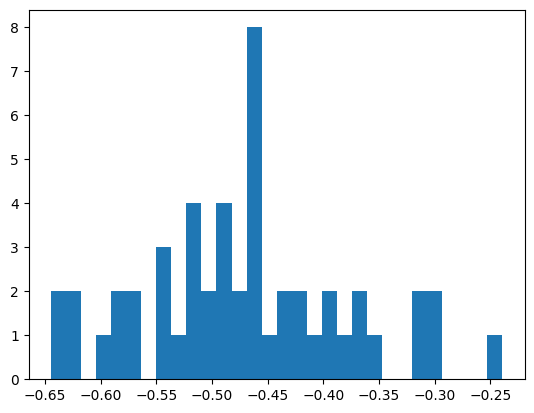

In [30]:
plt.hist(scores, bins=30)

In [31]:
np.median(scores)

-0.4718565046787262

### Inference

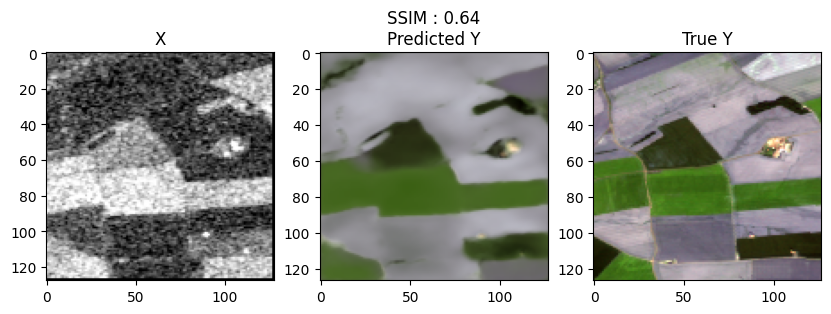

In [33]:
randindex = indexes[48]

img_y_hat = model(test_X[randindex:randindex+1])[:,:, :-1, :-1]
img_y = test_y[randindex:randindex+1,:,:,:]
img_x = test_X[randindex:randindex+1,:,:,:]

def post_process(imgs):
  return imgs[0].detach().cpu().numpy().transpose((1,2,0))*255


plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(array_to_img(post_process(img_x)))
plt.title('X')

plt.subplot(1,3,2)
plt.imshow(array_to_img(post_process(img_y_hat)))
plt.title(f'SSIM : {-loss_fn(img_y_hat, img_y):.2f}\nPredicted Y')

plt.subplot(1,3,3)
plt.imshow(array_to_img(post_process(img_y)))
plt.title('True Y')

plt.savefig('median_example.png', dpi=600)

In [ ]:
###

X_test = np.load("../public_data/NightVision.npy")
X_test = pad(torch.from_numpy(X_test.transpose((0,3,1,2))/255)).to(device)

predictions5 = model5(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255
predictions7 = model7(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255
predictions8 = model8(X_test).detach().cpu().numpy()[:,:,:-1,:-1].transpose((0,2,3,1))*255

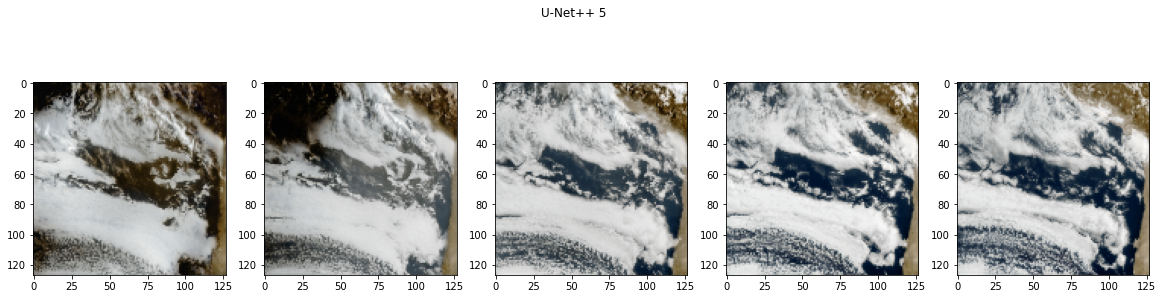

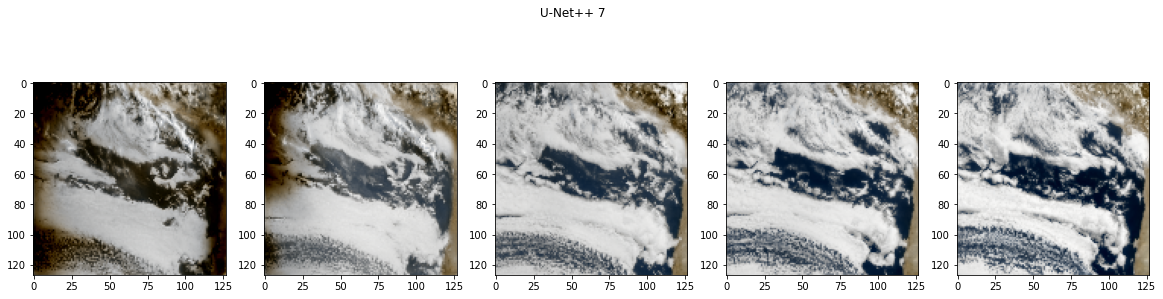

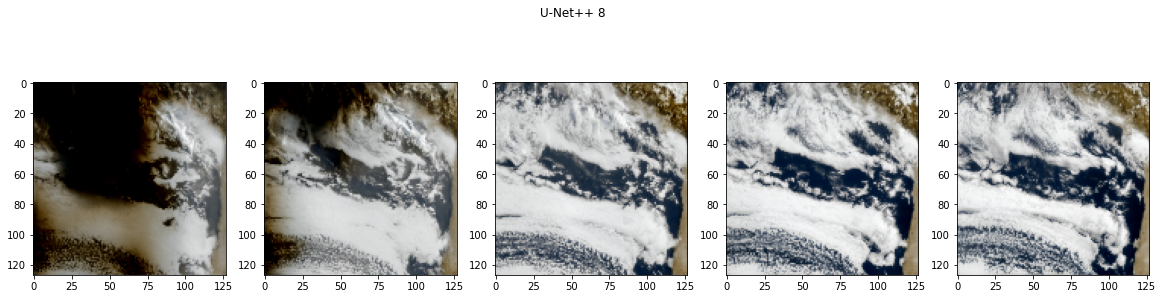

In [ ]:
ind=10
n=5

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 5')

for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions5[ind+i]))

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 7')

for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions7[ind+i]))

plt.figure(figsize=(20,5))
plt.suptitle('U-Net++ 8')
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(array_to_img(predictions8[ind+i]))


The figure above shows the predicted RBG images for the nighttime IR inuts. Our training data for each of these U-Net++ models had differening thresholds for excluding images. The higher the threshld, the less amount of darkness the network predicted.

We do better thresholding in the following notebooks.

In [ ]:
predictions_file = "predictions"

def save_compress(predictions, name):
    np.save(f'{predictions_file}/{name}.npy', predictions)
    os.system(f"mv {predictions_file}/{name}.npy {predictions_file}/{name}.predict")
    os.system(f"zip -jrm {predictions_file}/{name}.zip {predictions_file}/{name}.predict")
    os.system(f"rm {predictions_file}/{name}.predict")

save_compress(predictions5, 'Y_NightVision_stargazer')